# Tackle Overfitting with Data Augmentation

In [ ]:
import os
import shutil
import zipfile
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Getting and checking the data

In [ ]:
# Get a dataset of cats and dogs images
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"


--2023-10-25 09:52:43--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.245.101, 2a02:26f0:fe00:28f::317f, 2a02:26f0:fe00:295::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.245.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   161MB/s    in 5.0s    

2023-10-25 09:52:48 (159 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
# Extract images
zip_file = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# Check the directory structure
for root, dirs, files in os.walk('/tmp'):
 for dir in dirs:
    print(os.path.join(root, dir))


/tmp/initgoogle_syslog_dir.0
/tmp/pyright-251-jw7rI8hCL95G
/tmp/pyright-251-8FEDdQtEAIH2
/tmp/python-languageserver-cancellation
/tmp/PetImages
/tmp/python-languageserver-cancellation/eb873809d72191c49485d6f9c9edf511af6db42f7a
/tmp/PetImages/Dog
/tmp/PetImages/Cat


In [ ]:
# Check a number of images
cats_dir='/tmp/PetImages/Cat'
dogs_dir='/tmp/PetImages/Dog'
cats_files = os.listdir(cats_dir)
dogs_files = os.listdir(dogs_dir)
print(f'There are {len(cats_files)} cats images and {len(dogs_files)} dogs images.')

There are 12501 cats images and 12501 dogs images.


In [ ]:
# Defina a root directory
root_dir = '/tmp/cats-v-dogs'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# Make train and validation directories
train_dogs_dir = os.path.join(root_dir, 'train/dogs')
os.makedirs(train_dogs_dir)
train_cats_dir = os.path.join(root_dir, 'train/cats')
os.makedirs(train_cats_dir)
val_dogs_dir = os.path.join(root_dir, 'val/dogs')
os.makedirs(val_dogs_dir)
val_cats_dir = os.path.join(root_dir, 'val/cats')
os.makedirs(val_cats_dir)

In [ ]:
# Check the directory structure created
for root, dirs, files in os.walk(root_dir):
  for dir in dirs:
    print(os.path.join(root, dir))

/tmp/cats-v-dogs/train
/tmp/cats-v-dogs/val
/tmp/cats-v-dogs/train/dogs
/tmp/cats-v-dogs/train/cats
/tmp/cats-v-dogs/val/dogs
/tmp/cats-v-dogs/val/cats


## Splitting the data

In [ ]:
# Split data to train data and validation data
def split_data(source_dir, train_dir, val_dir, train_size):
  files = os.listdir(source_dir)
  train_files = random.sample(files, int(len(files)*train_size))
  val_files = [f for f in files if f not in train_files]

  # Copy files
  def copy_files(file_list, s_dir, d_dir):
    for f in file_list:
      s_path = os.path.join(s_dir, f)
      d_path = os.path.join(d_dir, f)
      if os.path.getsize(s_path) != 0:
        shutil.copyfile(s_path, d_path)
      else:
        print(f'File {f} has a zero size, so ignoring')

  copy_files(train_files, source_dir, train_dir)
  copy_files(val_files, source_dir, val_dir)


In [ ]:
# Empty directories in case they are not empty before copying files
def empty_dir(dir):
  if len(os.listdir(dir)) > 0:
    for file in os.scandir(dir):
      os.remove(file.path)

for dir in (train_cats_dir, val_cats_dir, train_dogs_dir, val_dogs_dir):
  empty_dir(dir)

# Split data and copy files to their respective directories
train_size = 0.9
split_data(cats_dir, train_cats_dir, val_cats_dir, train_size)
split_data(dogs_dir, train_dogs_dir, val_dogs_dir, train_size)

# Check the data split
print(f'Original dataset has {len(os.listdir(cats_dir))} images of cats and {len(os.listdir(dogs_dir))} images of dogs.')
print(f'There are {len(os.listdir(train_cats_dir))} images of cats for training and {len(os.listdir(val_cats_dir))} images of cats for validation now.')
print(f'There are {len(os.listdir(train_dogs_dir))} images of dogs for training and {len(os.listdir(val_dogs_dir))} images of dogs for validation now.')

File 666.jpg has a zero size, so ignoring
File 11702.jpg has a zero size, so ignoring
Original dataset has 12501 images of cats and 12501 images of dogs.
There are 11249 images of cats for training and 1251 images of cats for validation now.
There are 11249 images of dogs for training and 1251 images of dogs for validation now.


## Creating train and validation image data generators

In [ ]:
# Build train and validation image data generators
def get_image_data_generator(dir, train=True):
  if train:
    datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
  else:
    datagen = ImageDataGenerator(rescale=1/255)

  generator = datagen.flow_from_directory(
      directory=dir,
      target_size=(150,150),
      batch_size=25,
      class_mode='binary'
  )
  return generator


In [ ]:
# Get train and validation image data generators
train_generator = get_image_data_generator(os.path.join(root_dir, 'train'))
val_generator = get_image_data_generator(os.path.join(root_dir, 'val'), train=False)

Found 22496 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


## Building and training the model

In [ ]:
# Build a model
def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
      MaxPooling2D(2,2),
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Conv2D(128, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(0.2),
      Dense(1)
  ])
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
# Check the model summary
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15)

Epoch 1/15
515/900 [================>.............] - ETA: 1:14 - loss: 0.6823 - accuracy: 0.5226

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


900/900 [==============================] - 197s 202ms/step - loss: 0.6673 - accuracy: 0.5491 - val_loss: 0.5788 - val_accuracy: 0.6415
Epoch 2/15
900/900 [==============================] - 183s 203ms/step - loss: 0.5934 - accuracy: 0.6577 - val_loss: 0.5108 - val_accuracy: 0.7130
Epoch 3/15
900/900 [==============================] - 180s 200ms/step - loss: 0.5603 - accuracy: 0.6929 - val_loss: 0.5320 - val_accuracy: 0.7626
Epoch 4/15
900/900 [==============================] - 182s 202ms/step - loss: 0.5330 - accuracy: 0.7148 - val_loss: 0.4980 - val_accuracy: 0.7726
Epoch 5/15
900/900 [==============================] - 181s 201ms/step - loss: 0.5130 - accuracy: 0.7310 - val_loss: 0.4199 - val_accuracy: 0.7654
Epoch 6/15
900/900 [==============================] - 180s 200ms/step - loss: 0.4868 - accuracy: 0.7537 - val_loss: 0.3862 - val_accuracy: 0.8213
Epoch 7/15
900/900 [==============================] - 180s 200ms/step - loss: 0.4673 - accuracy: 0.7696 - val_loss: 0.3806 - val_accura

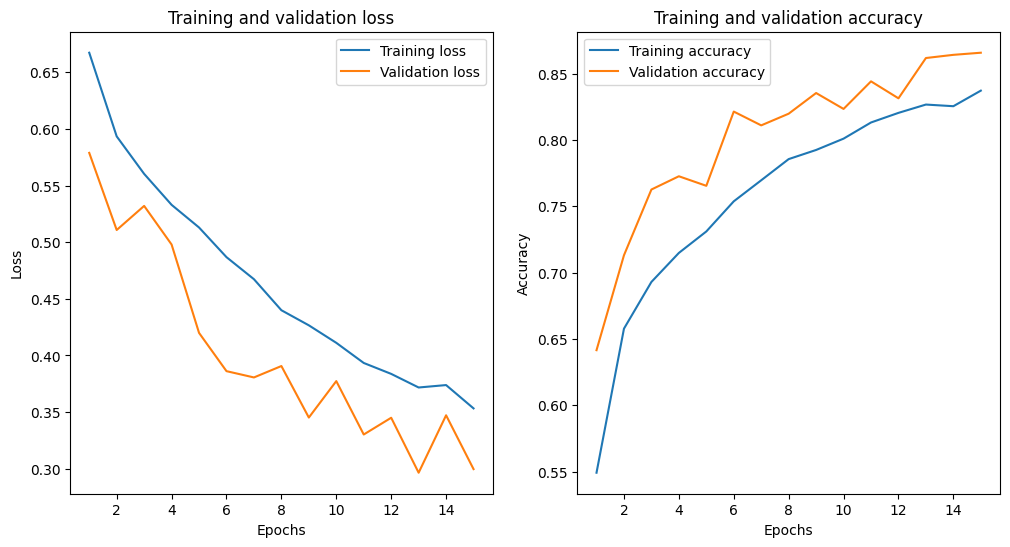

In [ ]:
# Plot the model training history
from math import ceil

def plot_history(params: list[str], val=True):
  num_rows = ceil(len(params)/2)
  epochs = [epoch for epoch in range(1, len(history.history[params[0]])+1)]
  plt.figure(figsize=(12, 6*num_rows))
  for i in range(len(params)):
    s = plt.subplot(num_rows, 2, i+1)
    par = params[i]
    s.plot(epochs, history.history[par], label=f'Training {par}')
    #s.set_xticks(epochs)
    s.set_xlabel('Epochs')
    s.set_ylabel(par.capitalize())
    if val:
      s.plot(epochs, history.history[f'val_{par}'], label=f'Validation {par}')
      s.set_title(f'Training and validation {par}')
    else:
      s.set_title(f'Training {par}')
    s.legend()

plot_history(['loss', 'accuracy'])